#### Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Data Preprocessing

In [2]:
fldr="/content/drive/MyDrive/UTKFace"

In [3]:
import os
files=os.listdir(fldr)


**get the data and prepare the training sets. The ‘images’ list contains all the 1176 images**

In [4]:
import cv2
ages=[]
genders=[]
images=[]

for fle in files:
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  total=fldr+'/'+fle
  print(total)
  image=cv2.imread(total)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(48,48))
  images.append(image)

  



/content/drive/MyDrive/UTKFace/15_1_0_20170109214352795.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_0_20170109214319385.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_1_20170104005130400.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_0_20170109214409051.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_0_20170109214307598.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_1_20170112191212510.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_0_20170109214024612.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_0_20170109214723528.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_0_20170109214626752.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_0_20170116232438243.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_0_20170109214302271.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_0_20170109214328421.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_3_20170104221722328.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_1_2_20170116175234078.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/15_

In [5]:
for fle in files:
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  ages.append(age)
  genders.append(gender)

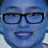

In [6]:
from google.colab.patches import cv2_imshow
cv2_imshow(images[24])

In [7]:
print(ages[24])
print(genders[24])

15
1


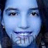

In [8]:
cv2_imshow(images[53])

In [9]:
print(ages[53])
print(genders[53])

15
1


In [10]:
import numpy as np
images_f=np.array(images)
genders_f=np.array(genders)
ages_f=np.array(ages)

In [11]:
np.save(fldr+'image.npy',images_f)
np.save(fldr+'gender.npy',genders_f)
np.save(fldr+'age.npy',ages_f)

**Male = 0**
**Female= 1**

In [12]:

values, counts = np.unique(genders_f, return_counts=True)
print(counts)

[632 544]


**Now, need to check the distribution of our sets.**

**The first bar graph shows the distribution of gender. It seems well balanced. The second line graph shows the variation of samples of different ages.**



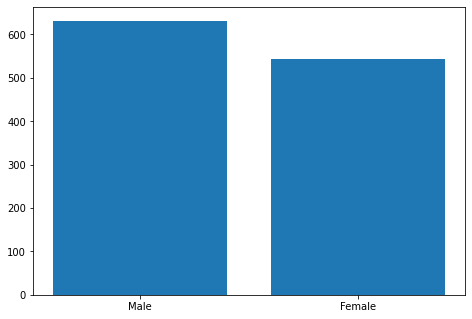

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
gender = ['Male', 'Female']
values=[632,544]
ax.bar(gender,values)
plt.show()

In [14]:

values, counts = np.unique(ages_f, return_counts=True)
print(counts)

[ 55 177 247 158 119 176 236   8]


In [15]:
val=values.tolist()
cnt=counts.tolist()

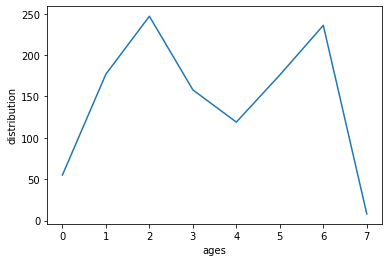

In [16]:
plt.plot(counts)
plt.xlabel('ages')
plt.ylabel('distribution')
plt.show()

**The below snippet takes the age and gender for each image sample index wise and converts each one into a list and appends them to the labels list. This is done to create the one-dimensional label vectors**.
**So, the shape of the ‘labels’ list will be: **

[[[age(1)],[gender(1)]],

[[age(2)],[gender(2)]], ……………….[[age(n)],[gender(n)]]]


In [17]:
labels=[]

i=0
while i<len(ages):
  label=[]
  label.append([ages[i]])
  label.append([genders[i]])
  labels.append(label)
  i+=1

**Next,  convert the labels and images list into NumPy arrays, normalize the images, and create the training and test data splits. using a 25% test split.**

In [18]:
images_f_2=images_f/255

In [19]:
labels_f=np.array(labels)

In [20]:
images_f_2.shape

(1176, 48, 48, 3)

In [21]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, Y_train, Y_test= train_test_split(images_f_2, labels_f,test_size=0.25)

In [23]:
Y_train[0:5]

array([[[16],
        [ 0]],

       [[55],
        [ 0]],

       [[56],
        [ 0]],

       [[16],
        [ 0]],

       [[18],
        [ 1]]])

 **Y_train[0] denotes the gender labels vector, and Y_train[1] denotes the age labels vector**


In [24]:
Y_train_2=[Y_train[:,1],Y_train[:,0]]
Y_test_2=[Y_test[:,1],Y_test[:,0]]

In [25]:
Y_train_2[0][0:5]

array([[0],
       [0],
       [0],
       [0],
       [1]])

In [26]:
Y_train_2[1][0:5]

array([[16],
       [55],
       [56],
       [16],
       [18]])

### Model

In [27]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x= Activation('relu')(x)

    return x
def model(input_shape):
  inputs = Input((input_shape))
  
  conv_1= Convolution(inputs,32)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,64)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,128)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,256)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  flatten= Flatten() (maxp_4)
  dense_1= Dense(64,activation='relu')(flatten)
  dense_2= Dense(64,activation='relu')(flatten)
  drop_1=Dropout(0.2)(dense_1)
  drop_2=Dropout(0.2)(dense_2)
  output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
  output_2= Dense(1,activation="relu",name='age_out')(drop_2)
  model = Model(inputs=[inputs], outputs=[output_1,output_2])
  model.compile(loss=["binary_crossentropy","mae"], optimizer="Adam",
	metrics=["accuracy"])
  
  return model


In [28]:
Model=model((48,48,3))

In [29]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 48, 48, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 32)   0           dropout[0][0]                    
______________________________________________________________________________________________

#### Training

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [31]:
fle_s='Age_sex_detection.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,Early_stop]

In [32]:
History=Model.fit(X_train,Y_train_2,batch_size=64,validation_data=(X_test,Y_test_2),epochs=500,callbacks=[callback_list])

Epoch 1/500
14/14 [==============================] - 33s 60ms/step - loss: 24.4274 - sex_out_loss: 0.7576 - age_out_loss: 23.4017 - sex_out_accuracy: 0.5057 - age_out_accuracy: 0.0000e+00 - val_loss: 22.4995 - val_sex_out_loss: 0.6860 - val_age_out_loss: 21.5761 - val_sex_out_accuracy: 0.5374 - val_age_out_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 22.49946, saving model to Age_sex_detection.h5
Epoch 2/500
14/14 [==============================] - 0s 14ms/step - loss: 17.7677 - sex_out_loss: 0.7068 - age_out_loss: 16.8402 - sex_out_accuracy: 0.5091 - age_out_accuracy: 0.0000e+00 - val_loss: 18.9817 - val_sex_out_loss: 0.6858 - val_age_out_loss: 18.0921 - val_sex_out_accuracy: 0.6156 - val_age_out_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 22.49946 to 18.98173, saving model to Age_sex_detection.h5
Epoch 3/500
14/14 [==============================] - 0s 14ms/step - loss: 17.1305 - sex_out_loss: 0.6806 - age_out_loss: 16.2559 - sex_out_accuracy: 0.5567 

### Evaluation

In [33]:
Model.evaluate(X_test,Y_test_2)

10/10 [==============================] - 0s 13ms/step - loss: 10.5178 - sex_out_loss: 0.5334 - age_out_loss: 9.5204 - sex_out_accuracy: 0.8333 - age_out_accuracy: 0.0000e+00


[10.517757415771484,
 0.5333877801895142,
 9.520434379577637,
 0.8333333134651184,
 0.0]

In [34]:
pred=Model.predict(X_test)

In [35]:
pred[1]

array([[16.170534 ],
       [33.40834  ],
       [14.206208 ],
       [13.738102 ],
       [15.660064 ],
       [14.262217 ],
       [32.976936 ],
       [14.656002 ],
       [17.113129 ],
       [26.266771 ],
       [33.416416 ],
       [15.181557 ],
       [28.674957 ],
       [15.780577 ],
       [13.179525 ],
       [37.90424  ],
       [28.736265 ],
       [13.452942 ],
       [18.415827 ],
       [29.246881 ],
       [19.904066 ],
       [33.28972  ],
       [18.567795 ],
       [15.978485 ],
       [15.766964 ],
       [15.364936 ],
       [15.039708 ],
       [30.808638 ],
       [14.216184 ],
       [14.620655 ],
       [35.899067 ],
       [34.418606 ],
       [35.26245  ],
       [12.803025 ],
       [22.23749  ],
       [14.340413 ],
       [13.793409 ],
       [49.16483  ],
       [15.060711 ],
       [32.04897  ],
       [39.187626 ],
       [20.740454 ],
       [25.286238 ],
       [13.0373535],
       [16.549685 ],
       [13.738102 ],
       [13.882498 ],
       [50.10

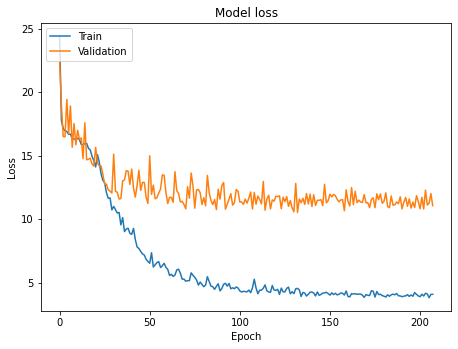

In [36]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

### For Gender

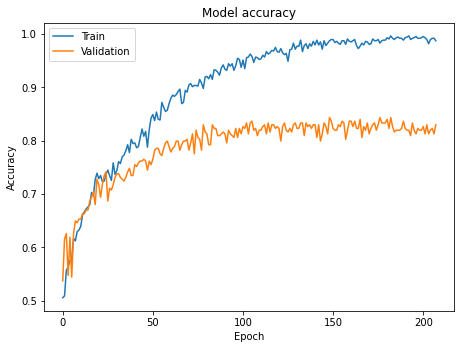

In [37]:
plt.plot(History.history['sex_out_accuracy'])
plt.plot(History.history['val_sex_out_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

### For age

**The below curve shows the model traced linear regression line in black and the blue dots show the distribution of test samples.**

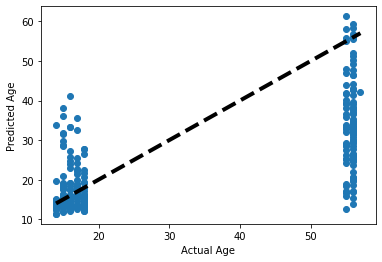

In [38]:
fig, ax = plt.subplots()
ax.scatter(Y_test_2[1], pred[1])
ax.plot([Y_test_2[1].min(),Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

#### For Gender

In [39]:
i=0
Pred_l=[]
while(i<len(pred[0])):

  Pred_l.append(int(np.round(pred[0][i])))
  i+=1


In [40]:
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import classification_report 

**model obtained an F1 score of 0.82 for the female gender and 0.85 for Male gender. So, it classifies male gender better than females.**

In [43]:

report=classification_report(Y_test_2[0], Pred_l)

In [44]:
print(report)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       158
           1       0.84      0.79      0.82       136

    accuracy                           0.83       294
   macro avg       0.83      0.83      0.83       294
weighted avg       0.83      0.83      0.83       294



In [45]:

results = confusion_matrix(Y_test_2[0], Pred_l)

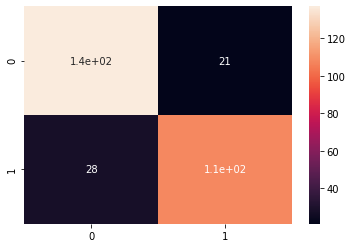

In [46]:
import seaborn as sns

sns.heatmap(results, annot=True)

In [47]:
def test_image(ind,images_f,images_f_2,Model):
  cv2_imshow(images_f[ind])
  image_test=images_f_2[ind]
  pred_1=Model.predict(np.array([image_test]))
  #print(pred_1)
  sex_f=['Male','Female']
  age=int(np.round(pred_1[1][0]))
  sex=int(np.round(pred_1[0][0]))
  print("Predicted Age: "+ str(age))
  print("Predicted Sex: "+ sex_f[sex])



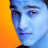

Predicted Age: 17
Predicted Sex: Male


In [48]:
test_image(57,images_f,images_f_2,Model)

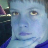

Predicted Age: 13
Predicted Sex: Male


In [49]:
test_image(137,images_f,images_f_2,Model)

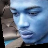

Predicted Age: 16
Predicted Sex: Male


In [50]:
test_image(502,images_f,images_f_2,Model)

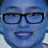

Predicted Age: 19
Predicted Sex: Male


In [51]:
test_image(24,images_f,images_f_2,Model)

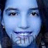

Predicted Age: 12
Predicted Sex: Female


In [52]:
test_image(53,images_f,images_f_2,Model)

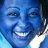

Predicted Age: 31
Predicted Sex: Female


In [53]:
test_image(969,images_f,images_f_2,Model)

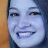

Predicted Age: 22
Predicted Sex: Female


In [54]:
test_image(551,images_f,images_f_2,Model)

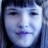

Predicted Age: 13
Predicted Sex: Female


In [55]:
test_image(1001,images_f,images_f_2,Model)